## Introducción¶
La regresión lineal sobresale en la extrapolación de tendencias, pero no puede aprender interacciones. XGBoost sobresale en las interacciones de aprendizaje, pero no puede extrapolar tendencias. En esta lección, aprenderemos a crear pronosticadores "híbridos" que combinan algoritmos de aprendizaje complementarios y permiten que las fortalezas de uno compensen las debilidades del otro.

fuente: https://www.kaggle.com/code/ryanholbrook/hybrid-models

# Componentes y residuos¶
Para que podamos diseñar híbridos efectivos, necesitamos una mejor comprensión de cómo se construyen las series de tiempo. Hemos estudiado hasta ahora tres patrones de dependencia: tendencia, estaciones y ciclos. Muchas series de tiempo se pueden describir con precisión mediante un modelo aditivo de solo estos tres componentes más algunos errores esencialmente impredecibles y completamente aleatorios:

serie = tendencia + temporadas + ciclos + error

A cada uno de los términos de este modelo lo llamaríamos componente de la serie temporal.

Los residuos de un modelo son la diferencia entre el objetivo en el que se entrenó el modelo y las predicciones que hace el modelo; en otras palabras, la diferencia entre la curva real y la curva ajustada. Grafique los residuos contra una característica y obtendrá la parte "sobrante" del objetivo, o lo que el modelo no pudo aprender sobre el objetivo de esa característica.

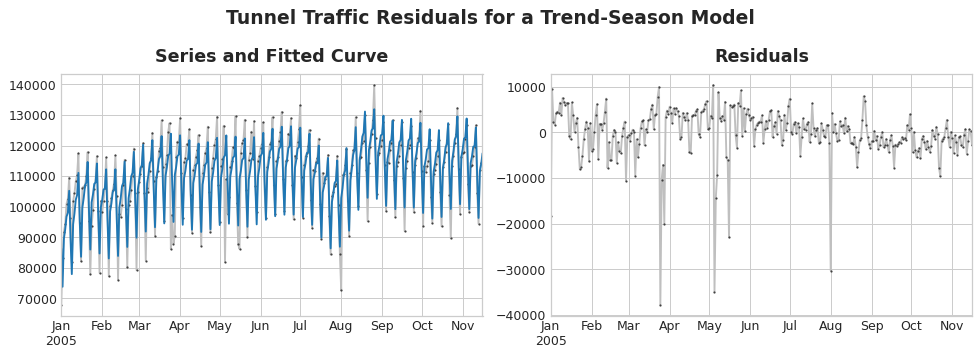

In [1]:
from IPython.display import Image
Image('../Kaglee/Data/Imagen_1_Lecc_5.png')

La diferencia entre la serie objetivo y la de prediccion (azul) uy la serie de los residuales (right)

A la izquierda de la figura anterior hay una porción de la serie Tunnel Traffic y la curva de tendencia estacional de la lección 3. Al restar la curva ajustada, quedan los residuos a la derecha. Los residuos contienen todo lo que no aprendió el modelo de tendencias estacionales del tráfico de túneles.

Podríamos imaginar aprender los componentes de una serie de tiempo como un proceso iterativo: primero aprender la tendencia y restarla de la serie, luego aprender la estacionalidad de los residuos sin tendencia y restar las estaciones, luego aprender los ciclos y restar los ciclos , y finalmente solo queda el error impredecible.

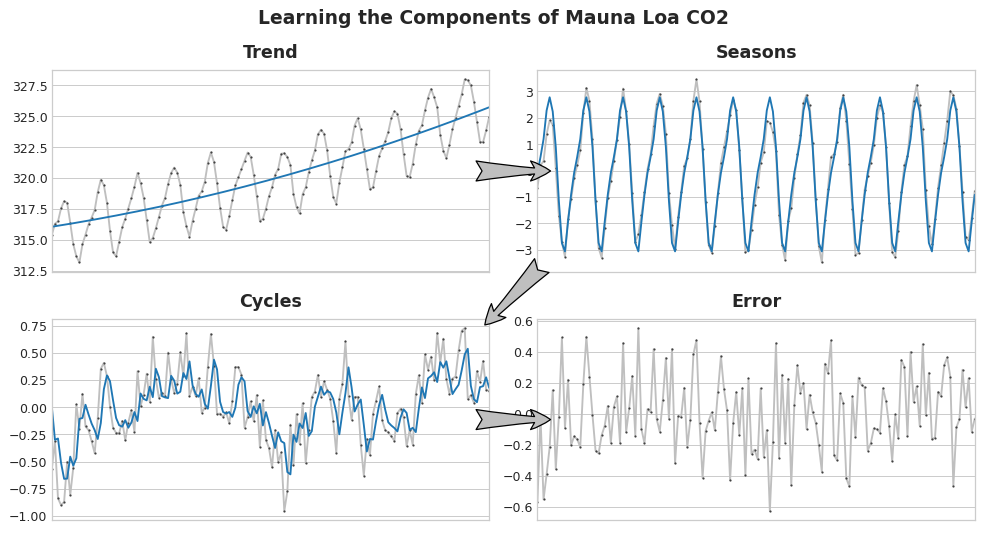

In [2]:
Image('../Kaglee/Data/Imagen_2_Lecc_5.png')

Aprendiendo los componentes de Mauna Loa CO2 paso a paso. Reste la curva ajustada (azul) de su serie para obtener la serie en el siguiente paso.

Suma todos los componentes que aprendimos y obtenemos el modelo completo. Esto es esencialmente lo que haría la regresión lineal si la entrenara en un conjunto completo de características que modelan tendencias, temporadas y ciclos.

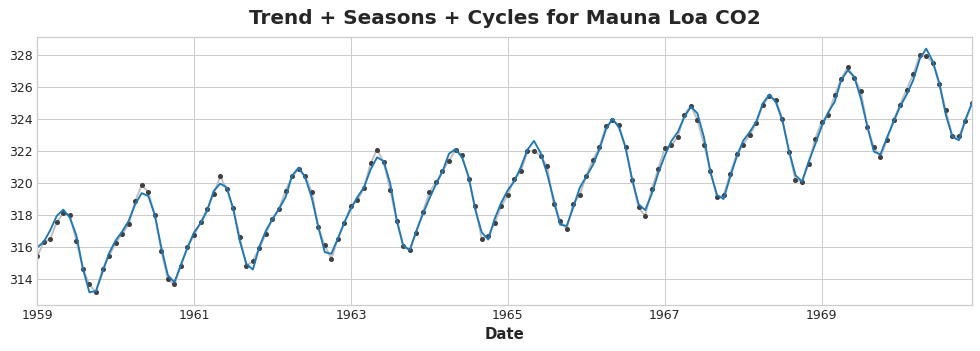

In [3]:
Image('../Kaglee/Data/Imagen_3_Lecc_5.png')

Agregue los componentes aprendidos para obtener un modelo completo.

# Pronóstico Híbrido con Residuales¶
En lecciones anteriores, usamos un solo algoritmo (regresión lineal) para aprender todos los componentes a la vez. Pero también es posible usar un algoritmo para algunos de los componentes y otro algoritmo para el resto. De esta manera siempre podemos elegir el mejor algoritmo para cada componente. Para hacer esto, usamos un algoritmo para ajustar la serie original y luego el segundo algoritmo para ajustar la serie residual.

En detalle, el proceso es este:

In [4]:
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

NameError: name 'model_1' is not defined

Por lo general, querremos usar diferentes conjuntos de funciones (X_train_1 y X_train_2 arriba) según lo que queremos que aprenda cada modelo. Si usamos el primer modelo para aprender la tendencia, generalmente no necesitaríamos una función de tendencia para el segundo modelo, por ejemplo.

Si bien es posible usar más de dos modelos, en la práctica no parece ser especialmente útil. De hecho, la estrategia más común para construir híbridos es la que acabamos de describir: un algoritmo de aprendizaje simple (generalmente lineal) seguido de un aprendiz no lineal complejo como GBDT o una red neuronal profunda, el modelo simple generalmente diseñado como un "ayudante" para el poderoso algoritmo que sigue.

### Diseñando Híbridos¶
Hay muchas maneras de combinar modelos de aprendizaje automático además de la forma que hemos descrito en esta lección. Sin embargo, la combinación exitosa de modelos requiere que profundicemos un poco más en cómo funcionan estos algoritmos.

En general, hay dos formas en que un algoritmo de regresión puede hacer predicciones: transformando las características o transformando el objetivo. Los algoritmos de transformación de características aprenden alguna función matemática que toma las características como entrada y luego las combina y transforma para producir una salida que coincida con los valores objetivo en el conjunto de entrenamiento. La regresión lineal y las redes neuronales son de este tipo.

Los algoritmos de transformación de objetivos utilizan las características para agrupar los valores objetivo en el conjunto de entrenamiento y hacer predicciones al promediar los valores en un grupo; un conjunto de características solo indica qué grupo promediar. Los árboles de decisión y los vecinos más cercanos son de este tipo.

Lo importante es esto: los transformadores de características generalmente pueden extrapolar valores objetivo más allá del conjunto de entrenamiento dadas las características apropiadas como entradas, pero las predicciones de los transformadores objetivo siempre estarán limitadas dentro del rango del conjunto de entrenamiento. Si la variable ficticia de tiempo continúa contando los pasos de tiempo, la regresión lineal continúa dibujando la línea de tendencia. Dada la misma variable ficticia de tiempo, un árbol de decisión predecirá la tendencia indicada por el último paso de los datos de entrenamiento hacia el futuro para siempre. Los árboles de decisión no pueden extrapolar tendencias. Los bosques aleatorios y los árboles de decisión potenciados por gradientes (como XGBoost) son conjuntos de árboles de decisión, por lo que tampoco pueden extrapolar tendencias.

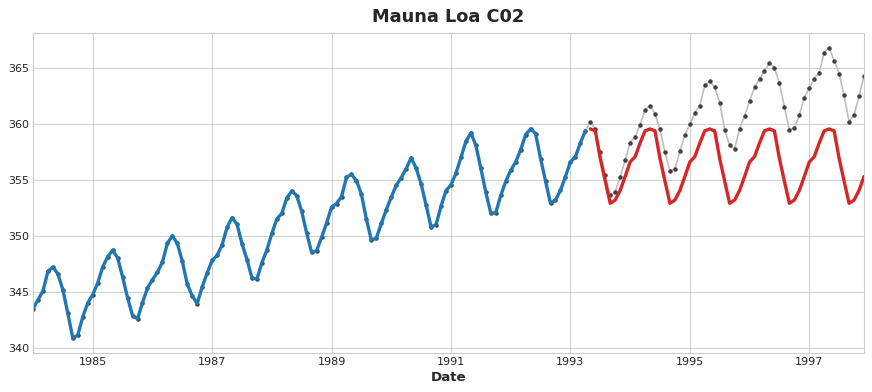

In [5]:
Image('../Kaglee/Data/Imagen_4_Lecc_5.png')

Un árbol de decisión no podrá extrapolar una tendencia más allá del conjunto de entrenamiento.

Esta diferencia es lo que motiva el diseño híbrido en esta lección: utilice la regresión lineal para extrapolar la tendencia, transforme el objetivo para eliminar la tendencia y aplique XGBoost a los residuos sin tendencia. Para hibridar una red neuronal (un transformador de funciones), podría incluir las predicciones de otro modelo como una función, que la red neuronal incluiría como parte de sus propias predicciones. El método de ajuste a los residuos es en realidad el mismo método que utiliza el algoritmo de refuerzo de gradiente, por lo que los llamaremos híbridos potenciados; el método de usar predicciones como características se conoce como "apilamiento", por lo que los llamaremos híbridos apilados.

## Ejemplo: ventas minoristas en EE. UU.¶
El conjunto de datos de ventas minoristas de EE. UU. contiene datos de ventas mensuales para varias industrias minoristas desde 1992 hasta 2019, según lo recopilado por la Oficina del Censo de EE. UU. Nuestro objetivo será pronosticar las ventas en los años 2016-2019 dadas las ventas en los años anteriores. Además de crear un híbrido de regresión lineal + XGBoost, también veremos cómo configurar un conjunto de datos de serie temporal para usar con XGBoost.

In [8]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)


industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    '../Kaglee/Data/us-retail-sales.csv',
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

Primero, usemos un modelo de regresión lineal para conocer la tendencia en cada serie. Para la demostración, usaremos una tendencia cuadrática (orden 2). (El código aquí es básicamente el mismo que el de las lecciones anteriores). Aunque el ajuste no es perfecto, será suficiente para nuestras necesidades.

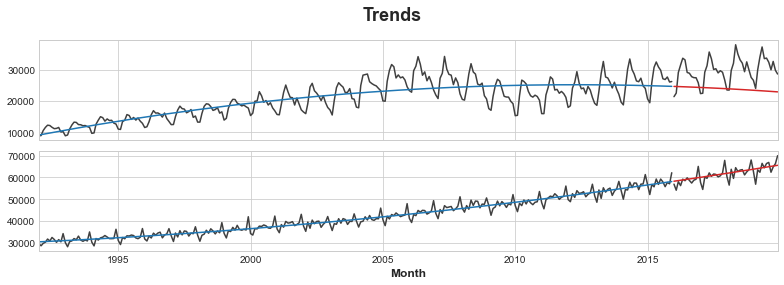

In [9]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Mientras que el algoritmo de regresión lineal es capaz de realizar una regresión de salida múltiple, el algoritmo XGBoost no lo es. Para predecir varias series a la vez con XGBoost, convertiremos estas series de formato ancho, con una serie temporal por columna, a formato largo, con series indexadas por categorías a lo largo de las filas.

In [12]:
retail.stack()

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608
...                             ...
2019-10-01 FoodAndBeverage    64849
2019-11-01 BuildingMaterials  29793
           FoodAndBeverage    66363
2019-12-01 BuildingMaterials  28621
           FoodAndBeverage    70028

[672 rows x 1 columns]

In [10]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Para que XGBoost pueda aprender a distinguir nuestras dos series temporales, convertiremos las etiquetas de fila de "Industrias" en una característica categórica con una codificación de etiquetas. También crearemos una función para la estacionalidad anual extrayendo los números de mes del índice de tiempo.

In [13]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Ahora convertiremos las predicciones de tendencias realizadas anteriormente a formato largo y luego las restaremos de la serie original. Eso nos dará series sin tendencia (residuales) que XGBoost puede aprender.

In [17]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

El ajuste parece bastante bueno, aunque podemos ver cómo la tendencia aprendida por XGBoost es tan buena como la tendencia aprendida por la regresión lineal; en particular, XGBoost no pudo compensar la tendencia de ajuste deficiente en los "Materiales de construcción". serie.

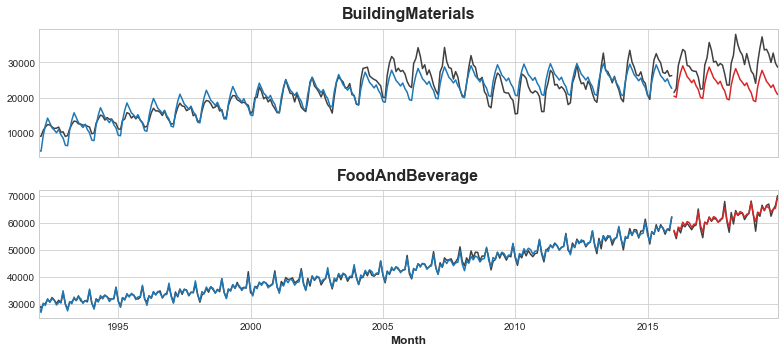

In [18]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])